## Hotel Recommendation
Author: Sanjay Jaras
DSC-630
Bellevue University

### Import Libraries

In [1]:
 import pandas as pd
 import numpy as np
 import seaborn as sns
 import vaex as vx
 import matplotlib.pyplot as plt
 import math
 from vaex import ml
 from sklearn.cluster import MiniBatchKMeans
 from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle

plt.style.use('fivethirtyeight') # For better style
random_state = 17

### Convert csv to hdf5, so that it can be loaded with vaex, quickly in future

In [2]:
%%time
train_data = vx.read_csv_and_convert("train.csv", parse_dates=['date_time'])

CPU times: user 11.2 ms, sys: 3.79 ms, total: 15 ms
Wall time: 535 ms


In [3]:
dest_data = vx.read_csv_and_convert("destinations.csv")

### Load training data

In [4]:
%%time
train_data = vx.open("train.csv.hdf5")

CPU times: user 12.3 ms, sys: 259 µs, total: 12.5 ms
Wall time: 12.1 ms


## Split Dataset in training and test set

In [5]:
train_data, test_data = train_data.ml.train_test_split(test_size=0.3)

/home/sanjay/anaconda3/lib/python3.8/site-packages/vaex/ml/__init__.py:209: UserWarning: Make sure the DataFrame is shuffled
  warnings.warn('Make sure the DataFrame is shuffled')


### Load test data

In [6]:
test_data.export_hdf5("test-data-split.hdf5", progress=True)

[########################################] 99.96% estimated time:     0.05s =  0.0m =  0.0h        

### Load destination 

In [7]:
dest_data = vx.open("destinations.csv.hdf5")

### Convert check-in date and check-out date columns to "Date" data type

In [8]:
train_data["srch_ci"] = train_data.srch_ci.astype("datetime64[D]")
train_data["srch_co"] = train_data.srch_co.astype("datetime64[D]")

### Summarize Training Data

In [9]:
train_data.info()

column,type,unit,description,expression
date_time,datetime64[ns],,,
site_name,int64,,,
posa_continent,int64,,,
user_location_country,int64,,,
user_location_region,int64,,,
user_location_city,int64,,,
orig_destination_distance,float64,,,
user_id,int64,,,
is_mobile,int64,,,
is_package,int64,,,


In [10]:
train_data.describe()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
dtype,datetime64[ns],int64,int64,int64,int64,int64,float64,int64,int64,int64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
count,26369205,26369205,26369205,26369205,26369205,26369205,16909509,26369205,26369205,26369205,...,26369205,26369205,26369205,26369205,26369205,26369205,26369205,26369205,26369205,26369205
NA,0,0,0,0,0,0,9459696,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mean,1970-01-01T00:05:18.254564602,9.813531503888722,2.6789699196468,86.05851518845563,309.47501193153147,27776.127663727442,1971.2217305138524,606413.2098481164,0.13502507944399536,0.24920800608133617,...,0.3325148407014925,1.1124188992425066,14447.344716915053,2.5821478501153146,0.0795925777815448,1.4829798243822672,3.159170365583642,81.30476523657046,600.3572388701139,49.817343829667976
std,17662585942218684.0,11.992394,0.750825,59.092629,209.171845,16778.877893,2232.510475,349817.585399,0.341750,0.432554,...,0.732027,0.458336,11073.331140,2.152793,0.270661,1.218338,1.625030,56.168760,511.940669,28.915763
min,2013-01-07T00:00:41.597009920,2,0,0,0,0,0.005600,0,0,0,...,0,0,0,0,0,1,0,0,0,0
max,2014-12-31T23:59:54.563395584,53,4,239,1027,56508,12281.641300,1198782,1,1,...,9,8,65107,9,1,269,6,212,2117,99


### Summarize Destination Data

In [11]:
dest_data.info()

column,type,unit,description,expression
srch_destination_id,int64,,,
d1,float64,,,
d2,float64,,,
d3,float64,,,
d4,float64,,,
d5,float64,,,
d6,float64,,,
d7,float64,,,
d8,float64,,,
d9,float64,,,


In [12]:
dest_data.describe()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
dtype,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
count,62106,62106,62106,62106,62106,62106,62106,62106,62106,62106,...,62106,62106,62106,62106,62106,62106,62106,62106,62106,62106
NA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mean,32359.463884326797,-2.1939032318063996,-2.2028544362513793,-2.2073905487681817,-2.194039670544935,-2.1614965229729304,-2.045110295419076,-2.2024330994997445,-2.203207293139685,-2.1078081438088043,...,-2.2040919397787224,-2.1969194438610438,-2.2032615050975024,-2.2051276104689266,-2.201924951668975,-2.203332024050514,-2.2029893378333054,-2.2083586793054852,-2.2082688195858133,-2.19946978747039
std,18711.615120,0.038575,0.041065,0.040091,0.041406,0.066196,0.135802,0.038885,0.036578,0.197902,...,0.037164,0.059913,0.046520,0.039465,0.041603,0.038239,0.051552,0.038035,0.038569,0.042438
min,0,-2.597617,-2.671613,-2.671613,-2.671613,-2.671613,-2.344165,-2.671613,-2.671613,-2.495544,...,-2.620769,-2.671613,-2.671613,-2.671613,-2.671613,-2.671613,-2.671613,-2.671613,-2.671613,-2.671613
max,64993,-1.596004,-1.341325,-1.917826,-1.814585,-1.607558,-1.209058,-1.474441,-1.879678,-0.977219,...,-1.855317,-0.960356,-1.357408,-1.775218,-1.790435,-1.799341,-1.335962,-1.816892,-1.718778,-1.500309


#### Function to plot multiple graphs in rows and columns for a dataframe

In [13]:
def plot_density_plots(features, df, ncol=3):
    cols = ncol
    rows = math.ceil(len(features)/cols) 
    fig, axes = plt.subplots(nrows = rows, ncols = cols, figsize=(20, rows*3))
    i = 0
    for col in tqdm(features):
        if(df[col].data_type() != str):
            plt.sca(axes[i//cols, i%cols])
            df.plot1d(col)
            i+=1
    plt.show() 

### Plot distribution plot for all numerical columns from Training Dataset

100%|██████████| 21/21 [00:04<00:00,  4.97it/s]


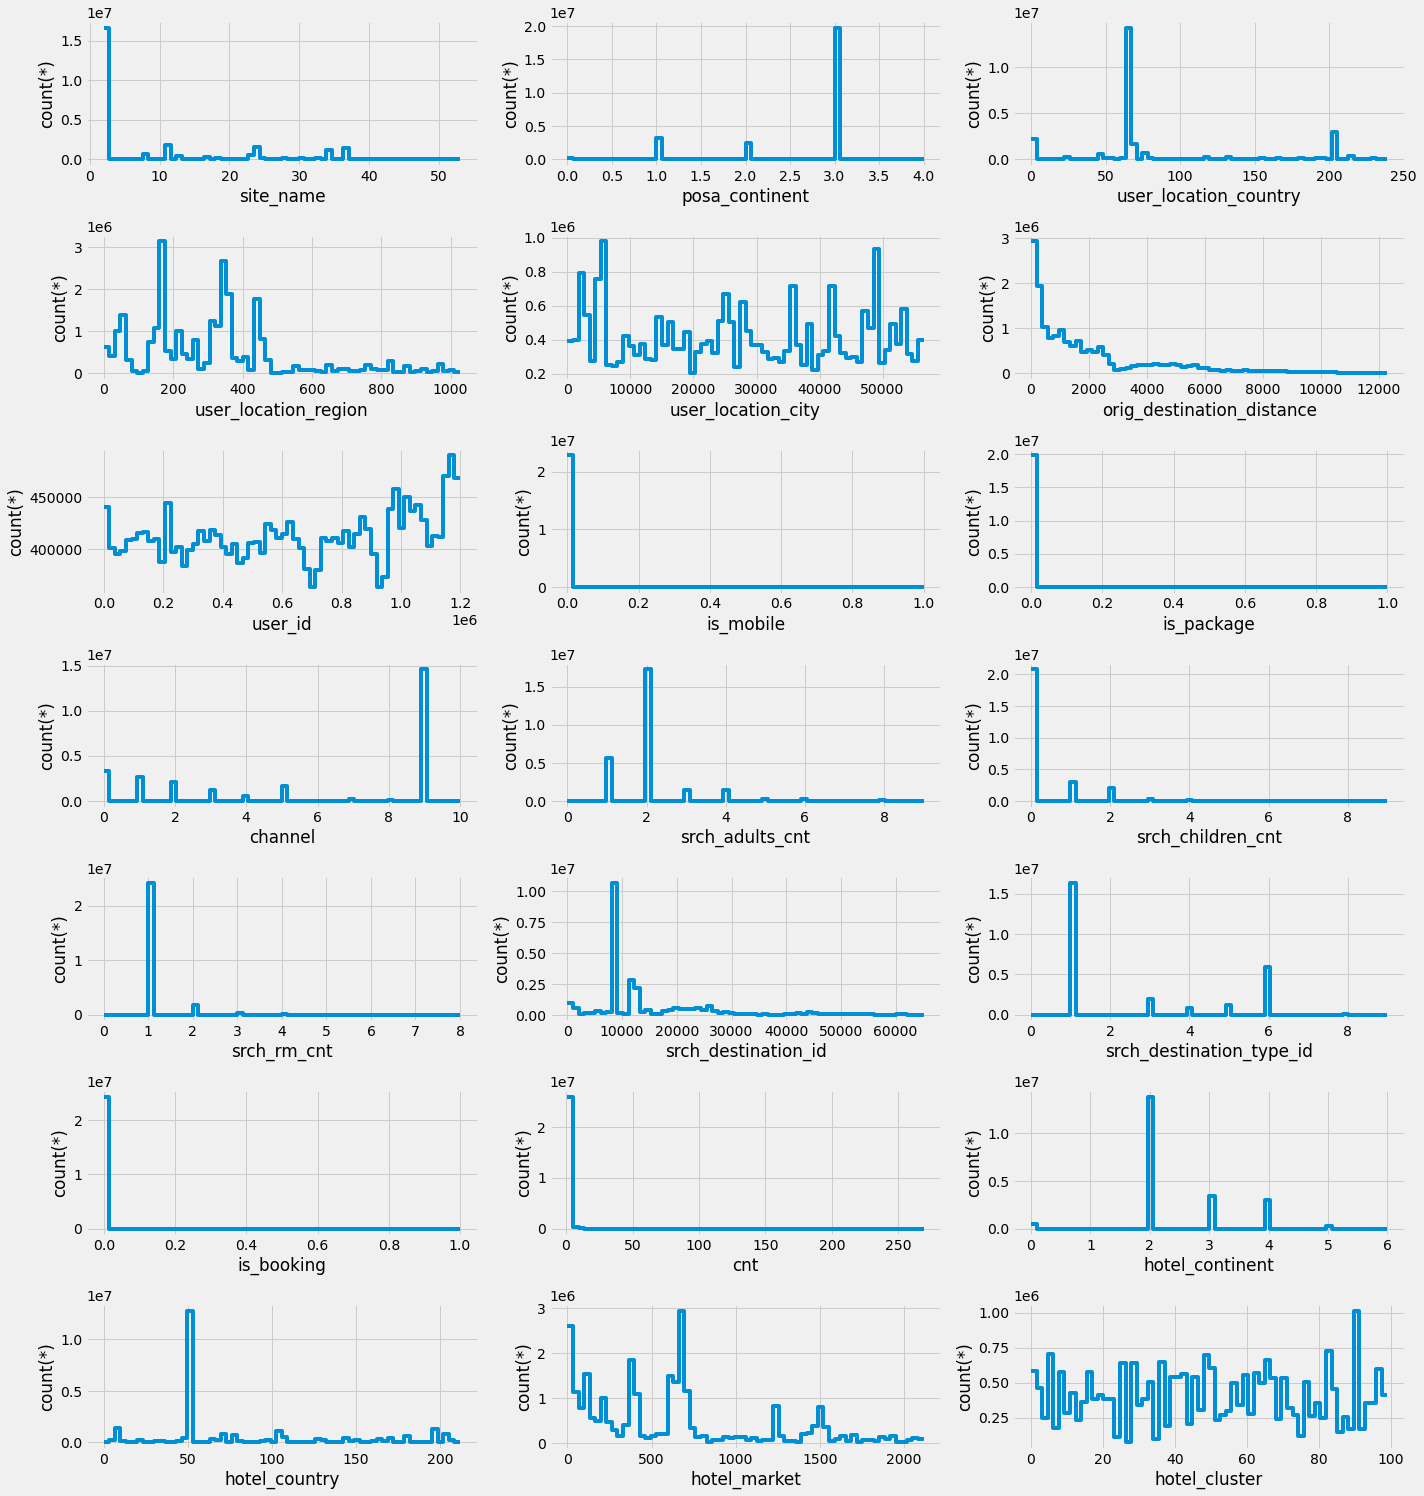

In [14]:
num_cols = [col for col in train_data.columns if train_data[col].data_type() != str and col != "date_time"]
plot_density_plots(num_cols, train_data)

### Plot Distribution plot for numeric fields from Destination csv

In [15]:
dest_train_col = [col for col in dest_data.column_names]
dest_train_col.remove('srch_destination_id')

100%|██████████| 149/149 [01:57<00:00,  1.27it/s]


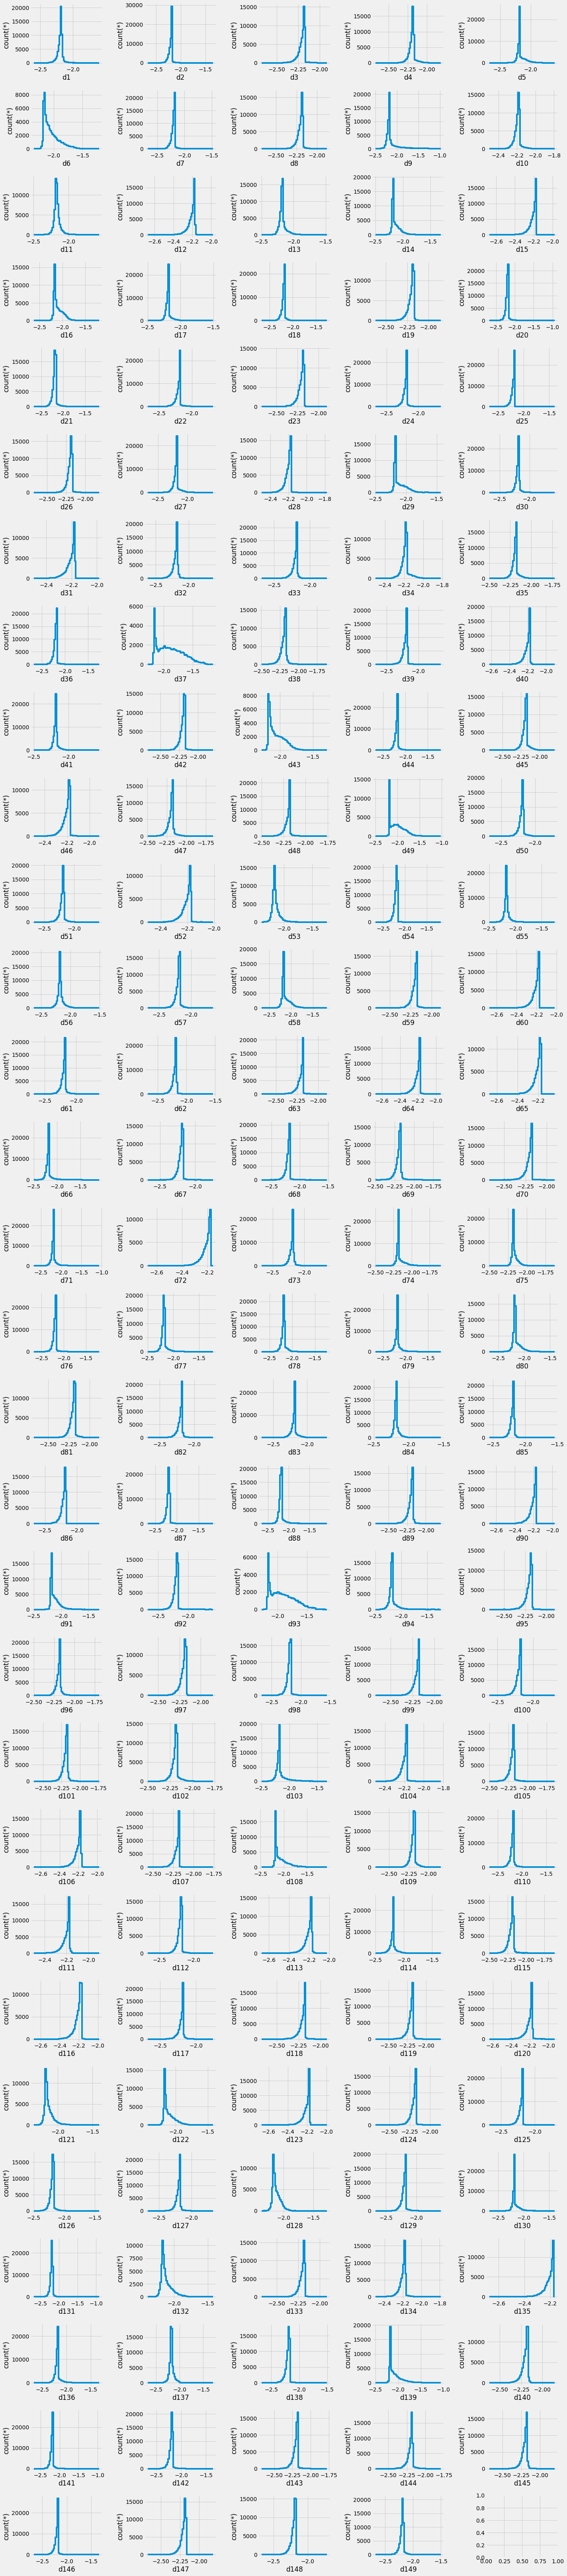

In [16]:
#commenting for time-being
plot_density_plots(dest_train_col, dest_data, ncol =5)

## Divide Destination data into clusters so that can be represented by sinle column 

### Scale destination data with standard scaler

In [17]:
scaler = ml.StandardScaler(features=dest_train_col, prefix='scaled_')
scaler.fit(dest_data)
df_trans = scaler.transform(dest_data)
df_trans

#,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149,scaled_d1,scaled_d2,scaled_d3,scaled_d4,scaled_d5,scaled_d6,scaled_d7,scaled_d8,scaled_d9,scaled_d10,scaled_d11,scaled_d12,scaled_d13,scaled_d14,scaled_d15,scaled_d16,scaled_d17,scaled_d18,scaled_d19,scaled_d20,scaled_d21,scaled_d22,scaled_d23,scaled_d24,scaled_d25,scaled_d26,scaled_d27,scaled_d28,scaled_d29,scaled_d30,scaled_d31,scaled_d32,scaled_d33,scaled_d34,scaled_d35,scaled_d36,scaled_d37,scaled_d38,scaled_d39,scaled_d40,scaled_d41,scaled_d42,scaled_d43,scaled_d44,scaled_d45,scaled_d46,scaled_d47,scaled_d48,scaled_d49,scaled_d50,scaled_d51,scaled_d52,scaled_d53,scaled_d54,scaled_d55,scaled_d56,scaled_d57,scaled_d58,scaled_d59,scaled_d60,scaled_d61,scaled_d62,scaled_d63,scaled_d64,scaled_d65,scaled_d66,scaled_d67,scaled_d68,scaled_d69,scaled_d70,scaled_d71,scaled_d72,scaled_d73,scaled_d74,scaled_d75,scaled_d76,scaled_d77,scaled_d78,scaled_d79,scaled_d80,scaled_d81,scaled_d82,scaled_d83,scaled_d84,scaled_d85,scaled_d86,scaled_d87,scaled_d88,scaled_d89,scaled_d90,scaled_d91,scaled_d92,scaled_d93,scaled_d94,scaled_d95,scaled_d96,scaled_d97,scaled_d98,scaled_d99,scaled_d100,scaled_d101,scaled_d102,scaled_d103,scaled_d104,scaled_d105,scaled_d106,scaled_d107,scaled_d108,scaled_d109,scaled_d110,scaled_d111,scaled_d112,scaled_d113,scaled_d114,scaled_d115,scaled_d116,scaled_d117,scaled_d118,scaled_d119,scaled_d120,scaled_d121,scaled_d122,scaled_d123,scaled_d124,scaled_d125,scaled_d126,scaled_d127,scaled_d128,scaled_d129,scaled_d130,scaled_d131,scaled_d132,scaled_d133,scaled_d134,scaled_d135,scaled_d136,scaled_d137,scaled_d138,scaled_d139,scaled_d140,scaled_d141,scaled_d142,scaled_d143,scaled_d144,scaled_d145,scaled_d146,scaled_d147,scaled_d148,scaled_d149
0,0,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.1986

### Predict cluster for each records from destination csv using MiniBatchKMeans

In [18]:
features = [col for col in df_trans.column_names if col.startswith("scaled_")]
df_train_dest = df_trans[features]
train_X, test_Y = train_test_split(df_train_dest.values, test_size=0.2)
review_cluster_model = MiniBatchKMeans(n_clusters = 50, random_state=random_state)
miniBatch = GridSearchCV(review_cluster_model,param_grid={"max_iter":[100, 500], "batch_size":[100, 1000, 10000, 20000]}, cv=2, verbose=2, n_jobs=8)
miniBatch.fit(train_X)
print(miniBatch.best_score_)
print(miniBatch.best_params_)

review_cluster_model = MiniBatchKMeans(n_clusters = 50, max_iter=100,batch_size=20000,  random_state=random_state)
labels = review_cluster_model.fit_predict(df_train_dest)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    4.7s remaining:    2.8s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    5.4s finished


-1374461.5630523567
{'batch_size': 20000, 'max_iter': 100}


### Add predicted cluster as a column in destination data

In [19]:
dest_data["review_cluster"]=labels
dest_data

#,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149,review_cluster
0,0,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-2.19865708695,-1.89762709129,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,-2.19865708695,24
1,1,-2.18169033283,-2.18169033283,-2.18169033283,-2.0825639033,-2.18169033283,-2.1650283759,-2.18169033283,-2.18169033283,-2.03159741039,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.04378933875,-2.18169033283,-2.18169033283,-2.18169033283,-2.1650283759,-2.18169033283,-2.13350766626,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.13350766626,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.0825639033,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.18169033283,-2.1

### Save the model, so that if requiered we can  use it in future.

In [20]:
pickle.dump(review_cluster_model, open("review-cluster-model.sav", 'wb'))

### Distribution plot for Review clusters from destinations csv

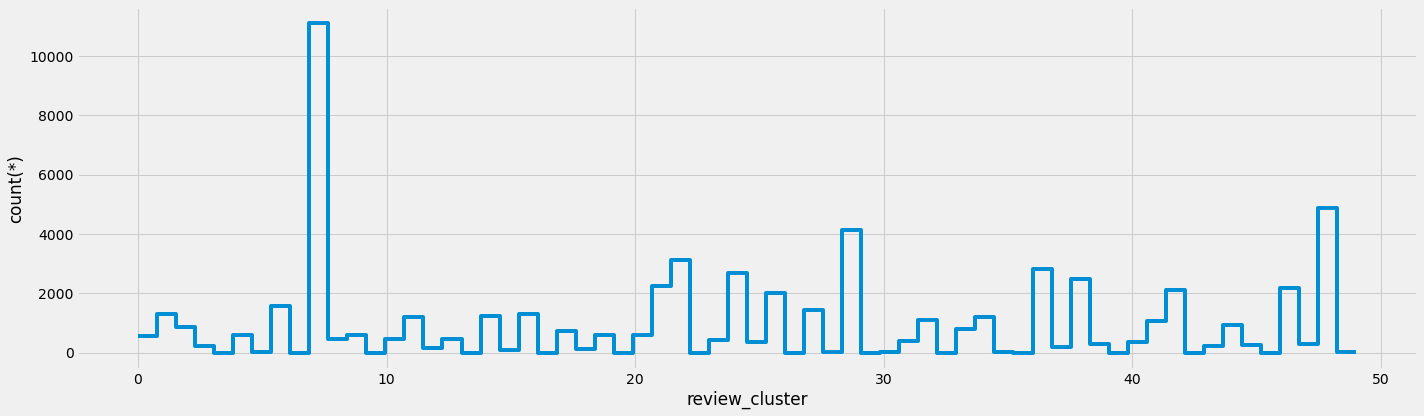

In [21]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 6))
dest_data.plot1d(dest_data["review_cluster"])

## Add Review clusters in training dataset by using search destination id field.

In [22]:
review_df = dest_data["srch_destination_id", "review_cluster"]
combine_df = train_data.join(review_df, how="left", on="srch_destination_id", rprefix="")

### Save destination dataset with cluster to be used with test data

In [23]:
dest_data.export_hdf5("destination-data-with-clusters.hdf5", progress=True)

[----------------------------------------] 60.26% estimated time:     0.10s =  0.0m =  0.0h 

### Observe the values from review clusters

In [24]:
combine_df.review_cluster.unique()

/home/sanjay/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


array([nan,  4.,  8., 45., 37., 32., 46., 27., 13.,  6., 20., 39.,  9.,
       12., 26., 16., 42.,  1., 22., 47., 23., 21., 17., 24., 48., 29.,
        2., 25., 44., 31., 19., 40.,  3., 36.,  7., 43., 41., 11., 34.,
       38., 14., 33., 10.,  0., 15., 35.,  5., 18., 28., 30., 49.])

## Fill Review Category as 99 for records with no reviews(No record exists in Destination csv)

In [25]:
combine_df.fillna(99, column_names=["review_cluster"], inplace=True)
combine_df["review_cluster"] = combine_df.review_cluster.fillmissing(99)
combine_df.review_cluster.unique()

array([31, 45, 16, 42,  4, 46,  6, 26, 44, 24, 17, 99, 22, 12, 32, 48, 34,
        8, 21, 47, 13, 39,  7, 19, 27, 36, 29, 23, 41, 38, 11, 37,  9,  2,
       40,  1, 33, 25,  3, 18, 10, 20, 43, 14, 15,  0,  5, 35, 30, 28, 49])

In [26]:
combine_train = combine_df

## Remove Outliers by check-in date
Records with check-in date greater than 1-Jan 2020 are removed

In [27]:
print("Before Removing Outlier by Check-in Date", combine_train.count())
combine_train = combine_train[combine_train.srch_ci<np.datetime64('2020-01-01')]
print("Aftre Removing Outlier by Check-in Date", combine_train.count())

Before Removing Outlier by Check-in Date 26369205
Aftre Removing Outlier by Check-in Date 26336326


## Remove Outliers by check-out date
Records with check-out date greater than 1-Jan 2020 are removed

In [28]:
print("Before Removing Outlier by Check-out Date", combine_train.count())
combine_train = combine_train[combine_train.srch_co<np.datetime64('2020-01-01')]
print("Aftre Removing Outlier by Check-out Date", combine_train.count())

Before Removing Outlier by Check-out Date 26336326
Aftre Removing Outlier by Check-out Date 26336322


## Find Missing values

In [29]:
columns = [col for col in combine_train.columns ]
for col in tqdm(columns):
    print(col, combine_train[col].ismissing().sum() + combine_train[col].isna().sum())

  8%|▊         | 2/25 [00:00<00:01, 11.80it/s]

date_time 0
site_name 0
posa_continent 0


 16%|█▌        | 4/25 [00:00<00:01, 12.91it/s]

user_location_country 0
user_location_region 0


 24%|██▍       | 6/25 [00:00<00:01, 13.38it/s]

user_location_city 0


 32%|███▏      | 8/25 [00:00<00:01, 13.71it/s]

orig_destination_distance 9446084
user_id 0
is_mobile 0


 40%|████      | 10/25 [00:00<00:01, 13.78it/s]

is_package 0
channel 0


 48%|████▊     | 12/25 [00:01<00:01,  7.94it/s]

__srch_ci 0


 56%|█████▌    | 14/25 [00:01<00:01,  6.30it/s]

__srch_co 0
srch_adults_cnt 0
srch_children_cnt 0


 72%|███████▏  | 18/25 [00:01<00:00,  8.92it/s]

srch_rm_cnt 0
srch_destination_id 0
srch_destination_type_id 0


 80%|████████  | 20/25 [00:02<00:00, 10.17it/s]

is_booking 0
cnt 0
hotel_continent 0


 96%|█████████▌| 24/25 [00:02<00:00, 11.91it/s]

hotel_country 0
hotel_market 0
hotel_cluster 0


100%|██████████| 25/25 [00:02<00:00, 10.24it/s]

__review_cluster 231344


## Replace Missing Values

In [30]:
print(combine_train["review_cluster"].ismissing().sum(progress=True))
print(combine_train["srch_ci"].ismissing().sum(progress=True))
print(combine_train["srch_co"].ismissing().sum(progress=True))

[##--------------------------------------] 100.00% elapsed time  :     0.06s =  0.0m =  0.0h
 0
[#####-----------------------------------] 100.00% elapsed time  :     4.23s =  0.1m =  0.0h
 0
[###-------------------------------------] 100.00% elapsed time  :     4.32s =  0.1m =  0.0h
 0


## Drop columns with more than 50% missing values
### Find Percentage of missing value for orig_destination_distance

In [31]:
print("Precentage of missing values", combine_train.orig_destination_distance.isna().sum()/combine_train.orig_destination_distance.count()*100)

Precentage of missing values 55.926293045722616


### Let's drop This column as it is having more than 50% missing values

In [32]:
combine_train.drop(columns = ["orig_destination_distance"], inplace=True)

#,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,review_cluster
0,2013-11-26 19:53:59.000000000,37,1,69,693,19647,242637,1,1,9,2014-01-21,2014-01-31,2,1,1,8976,1,0,2,4,52,202,26,25
1,2013-11-26 20:01:11.000000000,37,1,69,693,19647,242637,1,1,9,2014-01-20,2014-01-30,2,1,1,8976,1,0,3,4,52,202,26,25
2,2013-11-26 20:05:05.000000000,37,1,69,693,19647,242637,1,1,9,2014-01-20,2014-01-30,2,1,1,8976,1,0,3,4,52,202,0,25
3,2013-11-26 20:06:21.000000000,37,1,69,693,19647,242637,1,1,9,2014-01-20,2014-01-30,2,1,1,8976,1,0,1,4,52,202,90,25
4,2013-11-26 21:54:38.000000000,37,1,69,693,19647,242637,1,1,0,2014-01-20,2014-01-30,2,1,1,8976,1,0,1,4,52,202,26,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"26,336,317",2014-09-02 08:08:28.000000000,2,3,66,174,26232,1198182,0,1,2,2014-11-16,2014-11-22,2,0,1,8855,1,0,1,2,50,213,26,31
"26,336,318",2014-09-08 14:52:52.000000000,2,3,66,174,26232,1198182,0,0,0,2014-10-20,2014-10-25,1,0,1,8281,1,0,1,2,50,663,9,17
"26,336,319",2014-09-15 06:56:51.000000000,2,3,66,174,26232,1198182,0,0,0,2014-09-15,2014-09-16,1,0,1,5620,3,0,1,2,50,663,94,42
"26,336,320",2014-09-18 08:49:33.000000000,2,3,66,462,12565,1198182,0,0,0,2014-09-18,2014-09-19,1,0,1,18811,1,0,1,2,50,592,42,42


## Add column "days" from Check-out date and check-in date
### Calculate days from check-out and check-in

In [33]:
combine_train["days"] = combine_train["srch_co"] - combine_train["srch_ci"]
combine_train["days"] = combine_train["days"] / np.timedelta64(1, 'D')
combine_train["days"] 

Expression = days
Length: 26,336,322 dtype: float64 (column)
------------------------------------------
       0  10
       1  10
       2  10
       3  10
       4  10
    ...     
26336317   6
26336318   5
26336319   1
26336320   1
26336321   1

## Observe distribtuion for days column

In [34]:
days_ser = pd.Series(combine_train.days.values)
days_ser.describe()

count    2.633632e+07
mean     3.370079e+00
std      3.235120e+00
min     -3.970000e+02
25%      1.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      4.270000e+02
dtype: float64

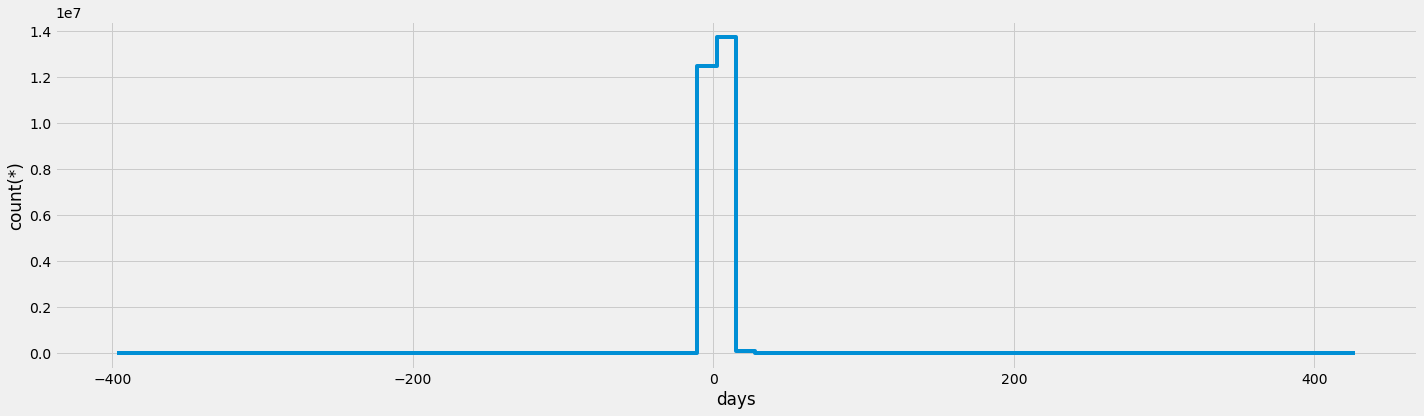

In [35]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 6))
combine_train.plot1d(combine_train["days"])

## Remove Outliers by number of days of stays

In [36]:
days_ser.quantile([0.05, 0.99])

0.05     1.0
0.99    14.0
dtype: float64

In [37]:
print("Before Removing Outlier by Days", combine_train.count())
combine_train = combine_train[(combine_train.days>0) & (combine_train.days<15)]
#combine_df = combine_df[combine_df.days<15]
print("Aftre Removing Outlier by Days", combine_train.count())

Before Removing Outlier by Days 26336322
Aftre Removing Outlier by Days 26055802


### Distribution of days columns after removing outliers

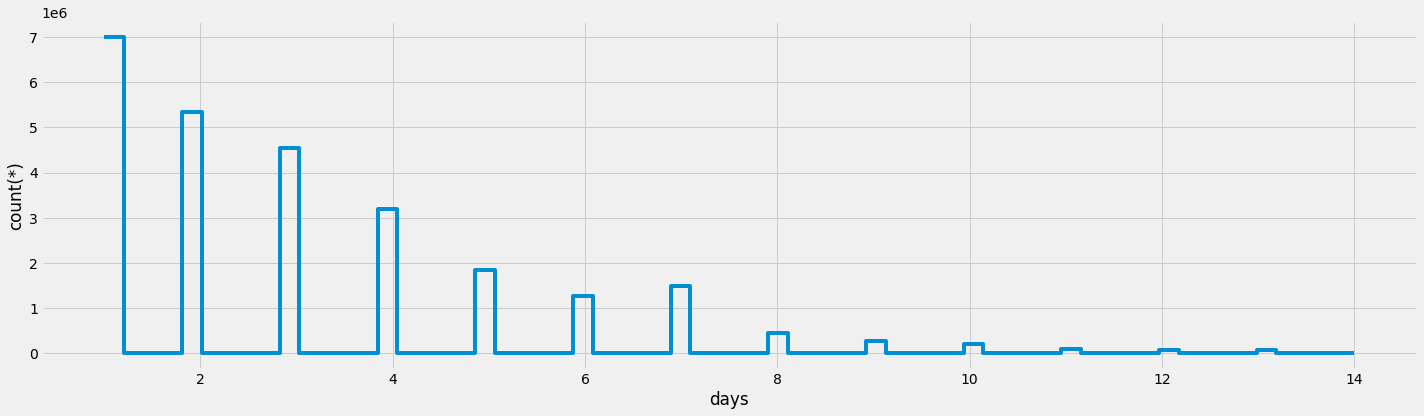

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 6))
combine_train.plot1d(combine_train["days"])

## Add custom Columns from date time column

In [39]:
combine_train["ev_day"] = combine_train.date_time.dt.day
combine_train["ev_month"] = combine_train.date_time.dt.month
combine_train["ev_hour"] = combine_train.date_time.dt.hour
combine_train.head(5)

#,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,review_cluster,days,ev_day,ev_month,ev_hour
0,2013-11-26 19:53:59.000000000,37,1,69,693,19647,242637,1,1,9,2014-01-21,2014-01-31,2,1,1,8976,1,0,2,4,52,202,26,25,10,26,11,19
1,2013-11-26 20:01:11.000000000,37,1,69,693,19647,242637,1,1,9,2014-01-20,2014-01-30,2,1,1,8976,1,0,3,4,52,202,26,25,10,26,11,20
2,2013-11-26 20:05:05.000000000,37,1,69,693,19647,242637,1,1,9,2014-01-20,2014-01-30,2,1,1,8976,1,0,3,4,52,202,0,25,10,26,11,20
3,2013-11-26 20:06:21.000000000,37,1,69,693,19647,242637,1,1,9,2014-01-20,2014-01-30,2,1,1,8976,1,0,1,4,52,202,90,25,10,26,11,20
4,2013-11-26 21:54:38.000000000,37,1,69,693,19647,242637,1,1,0,2014-01-20,2014-01-30,2,1,1,8976,1,0,1,4,52,202,26,25,10,26,11,21


### Define columns

In [40]:
target_variable = 'hotel_cluster'
cols_to_drop = ['date_time','srch_ci', 'srch_co', target_variable]
col_names = [col for col in combine_train.column_names if col not in cols_to_drop and not col.startswith("__")]
col_names

['site_name',
 'posa_continent',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'user_id',
 'is_mobile',
 'is_package',
 'channel',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'srch_destination_id',
 'srch_destination_type_id',
 'is_booking',
 'cnt',
 'hotel_continent',
 'hotel_country',
 'hotel_market',
 'review_cluster',
 'days',
 'ev_day',
 'ev_month',
 'ev_hour']

In [41]:
combine_train.shape

(26055802, 28)

## Feature selection by SelectKBest

In [42]:
first_1_mill = combine_train.head(1_000_000)

In [43]:
selector = SelectKBest(chi2, k='all')
fit = selector.fit(first_1_mill[col_names].values, first_1_mill[target_variable].values)

#X_new.shape


In [44]:
# summarize scores
scores = fit.scores_
for i in range(len(col_names)):
    print("%s: %0.2f" % (col_names[i].rjust(25, ' ') , np.log10(scores[i])))
    i += 1

                site_name: 6.11
           posa_continent: 4.28
    user_location_country: 5.05
     user_location_region: 6.08
       user_location_city: 6.83
                  user_id: 8.30
                is_mobile: 3.35
               is_package: 4.85
                  channel: 3.80
          srch_adults_cnt: 3.33
        srch_children_cnt: 4.49
              srch_rm_cnt: 2.52
      srch_destination_id: 8.40
 srch_destination_type_id: 4.68
               is_booking: 3.99
                      cnt: 3.80
          hotel_continent: 5.40
            hotel_country: 6.73
             hotel_market: 7.31
           review_cluster: 6.09
                     days: 5.21
                   ev_day: 3.13
                 ev_month: 3.84
                  ev_hour: 3.37


/home/sanjay/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


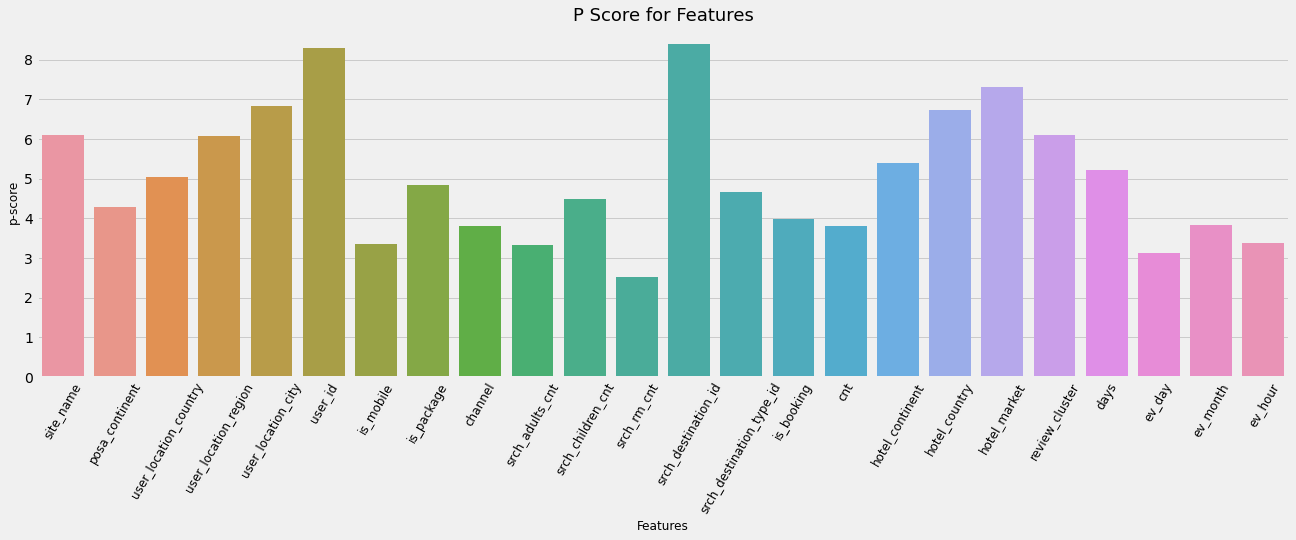

In [45]:
ser = pd.Series(fit.scores_)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 6))
sns.barplot(col_names, np.log10(ser))
plt.xticks(rotation=60, fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.ylabel("p-score", fontsize=12)
plt.title("P Score for Features", fontsize=18)
plt.show()

In [46]:
columns_to_ignore = ["srch_rm_cnt", "is_mobile", "srch_adults_cnt", "ev_day"]
columns_for_model = [col for col in col_names if col not in columns_to_ignore]
scaler = ml.StandardScaler(features=columns_for_model, prefix='scaled_')
scaler.fit(combine_train)
combine_df_scaled = scaler.transform(combine_train)
combine_df_scaled.head(5)

#,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,review_cluster,days,ev_day,ev_month,ev_hour,scaled_site_name,scaled_posa_continent,scaled_user_location_country,scaled_user_location_region,scaled_user_location_city,scaled_user_id,scaled_is_package,scaled_channel,scaled_srch_children_cnt,scaled_srch_destination_id,scaled_srch_destination_type_id,scaled_is_booking,scaled_cnt,scaled_hotel_continent,scaled_hotel_country,scaled_hotel_market,scaled_review_cluster,scaled_days,scaled_ev_month,scaled_ev_hour
0,2013-11-26 19:53:59.000000000,37,1,69,693,19647,242637,1,1,9,2014-01-21,2014-01-31,2,1,1,8976,1,0,2,4,52,202,26,25,10,26,11,19,2.26975,-2.24274,-0.287829,1.83644,-0.483952,-1.03992,1.75354,0.841894,0.912957,-0.495056,-0.736419,-0.29565,0.422329,0.519276,-0.521026,-0.779365,0.0450958,2.82355,1.17975,0.95445
1,2013-11-26 20:01:11.000000000,37,1,69,693,19647,242637,1,1,9,2014-01-20,2014-01-30,2,1,1,8976,1,0,3,4,52,202,26,25,10,26,11,20,2.26975,-2.24274,-0.287829,1.83644,-0.483952,-1.03992,1.75354,0.841894,0.912957,-0.495056,-0.736419,-0.29565,1.24154,0.519276,-0.521026,-0.779365,0.0450958,2.82355,1.17975,1.13103
2,2013-11-26 20:05:05.000000000,37,1,69,693,19647,242637,1,1,9,2014-01-20,2014-01-30,2,1,1,8976,1,0,3,4,52,202,0,25,10,26,11,20,2.26975,-2.24274,-0.287829,1.83644,-0.483952,-1.03992,1.75354,0.841894,0.912957,-0.495056,-0.736419,-0.29565,1.24154,0.519276,-0.521026,-0.779365,0.0450958,2.82355,1.17975,1.13103
3,2013-11-26 20:06:21.000000000,37,1,69,693,19647,242637,1,1,9,2014-01-20,2014-01-30,2,1,1,8976,1,0,1,4,52,202,90,25,10,26,11,20,2.26975,-2.24274,-0.287829,1.83644,-0.483952,-1.03992,1.75354,0.841894,0.912957,-0.495056,-0.736419,-0.29565,-0.396877,0.519276,-0.521026,-0.779365,0.0450958,2.82355,1.17975,1.13103
4,2013-11-26 21:54:38.000000000,37,1,69,693,19647,242637,1,1,0,2014-01-20,2014-01-30,2,1,1,8976,1,0,1,4,52,202,26,25,10,26,11,21,2.26975,-2.24274,-0.287829,1.83644,-0.483952,-1.03992,1.75354,-1.5801,0.912957,-0.495056,-0.736419,-0.29565,-0.396877,0.519276,-0.521026,-0.779365,0.0450958,2.82355,1.17975,1.30761


In [47]:
features = [col for col in combine_df_scaled.column_names if col.startswith("scaled_")]
features

['scaled_site_name',
 'scaled_posa_continent',
 'scaled_user_location_country',
 'scaled_user_location_region',
 'scaled_user_location_city',
 'scaled_user_id',
 'scaled_is_package',
 'scaled_channel',
 'scaled_srch_children_cnt',
 'scaled_srch_destination_id',
 'scaled_srch_destination_type_id',
 'scaled_is_booking',
 'scaled_cnt',
 'scaled_hotel_continent',
 'scaled_hotel_country',
 'scaled_hotel_market',
 'scaled_review_cluster',
 'scaled_days',
 'scaled_ev_month',
 'scaled_ev_hour']

In [48]:
features_to_save =features.copy()
features_to_save.append("hotel_cluster")
train_df_to_save = combine_df_scaled[features_to_save]
train_df_to_save.head(5)
train_df_to_save.export_hdf5("final-train-dataset.hdf5", progress=True)

[########################################] 99.99% estimated time:     0.04s =  0.0m =  0.0h                                                    

In [49]:
final_dataset = combine_df_scaled[features]
#final_dataset["hotel_cluster"] = combine_df_scaled.hotel_cluster
final_dataset.head(5)

#,scaled_site_name,scaled_posa_continent,scaled_user_location_country,scaled_user_location_region,scaled_user_location_city,scaled_user_id,scaled_is_package,scaled_channel,scaled_srch_children_cnt,scaled_srch_destination_id,scaled_srch_destination_type_id,scaled_is_booking,scaled_cnt,scaled_hotel_continent,scaled_hotel_country,scaled_hotel_market,scaled_review_cluster,scaled_days,scaled_ev_month,scaled_ev_hour
0,2.26975,-2.24274,-0.287829,1.83644,-0.483952,-1.03992,1.75354,0.841894,0.912957,-0.495056,-0.736419,-0.29565,0.422329,0.519276,-0.521026,-0.779365,0.0450958,2.82355,1.17975,0.95445
1,2.26975,-2.24274,-0.287829,1.83644,-0.483952,-1.03992,1.75354,0.841894,0.912957,-0.495056,-0.736419,-0.29565,1.24154,0.519276,-0.521026,-0.779365,0.0450958,2.82355,1.17975,1.13103
2,2.26975,-2.24274,-0.287829,1.83644,-0.483952,-1.03992,1.75354,0.841894,0.912957,-0.495056,-0.736419,-0.29565,1.24154,0.519276,-0.521026,-0.779365,0.0450958,2.82355,1.17975,1.13103
3,2.26975,-2.24274,-0.287829,1.83644,-0.483952,-1.03992,1.75354,0.841894,0.912957,-0.495056,-0.736419,-0.29565,-0.396877,0.519276,-0.521026,-0.779365,0.0450958,2.82355,1.17975,1.13103
4,2.26975,-2.24274,-0.287829,1.83644,-0.483952,-1.03992,1.75354,-1.5801,0.912957,-0.495056,-0.736419,-0.29565,-0.396877,0.519276,-0.521026,-0.779365,0.0450958,2.82355,1.17975,1.30761


## Randomly split dataset in 2 sets for model selection

### Splitting training set to into 2 sets for building models

In [50]:
final_1_train, final_rest_train, final_1_y, final_rest_y = train_test_split(final_dataset.values, combine_df_scaled.hotel_cluster.values,train_size=10_000,random_state=random_state)
final_2_train, final_rest_train, final_2_y, final_rest_y = train_test_split(final_rest_train, final_rest_y,train_size=10_000,random_state=random_state)

In [51]:
print(final_1_train.shape)
print(final_2_train.shape)

(10000, 20)
(10000, 20)


### Find all models with sklearn

In [52]:
from sklearn.base import ClassifierMixin
from sklearn.utils.testing import all_estimators
import sklearn

CLASSIFIERS = [est for est in all_estimators() if issubclass(est[1], ClassifierMixin)]

/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [53]:
removed_classifiers = [
    ("CheckingClassifier", sklearn.utils._mocking.CheckingClassifier),
    ("ClassifierChain", sklearn.multioutput.ClassifierChain),
    ("ComplementNB", sklearn.naive_bayes.ComplementNB),
    (
        "GradientBoostingClassifier",
        sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
    ),
    (
        "GaussianProcessClassifier",
        sklearn.gaussian_process.gpc.GaussianProcessClassifier,
    ),
    (
        "HistGradientBoostingClassifier",
        sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier,
    ),
    ("MLPClassifier", sklearn.neural_network.multilayer_perceptron.MLPClassifier),
    ("LogisticRegressionCV", sklearn.linear_model.logistic.LogisticRegressionCV),
    ("MultiOutputClassifier", sklearn.multioutput.MultiOutputClassifier),
    ("MultinomialNB", sklearn.naive_bayes.MultinomialNB),
    ("OneVsOneClassifier", sklearn.multiclass.OneVsOneClassifier),
    ("OneVsRestClassifier", sklearn.multiclass.OneVsRestClassifier),
    ("OutputCodeClassifier", sklearn.multiclass.OutputCodeClassifier),
    (
        "RadiusNeighborsClassifier",
        sklearn.neighbors.classification.RadiusNeighborsClassifier,
    ),
    ("VotingClassifier", sklearn.ensemble.voting.VotingClassifier),
    ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
]

for i in removed_classifiers:
    CLASSIFIERS.pop(CLASSIFIERS.index(i))

In [54]:
temp_list = []
for classifier in CLASSIFIERS:
    full_name = (classifier.__class__.__name__, classifier)
    temp_list.append(classifier)
classifiers = temp_list


In [55]:
clfs = []
for name, model in classifiers:
    #print(name)
    try:
        params = model().get_params().keys();
        if "random_state" in params and "n_jobs" in params:
            clf = model(random_state=random_state, n_jobs=-1)
        elif "random_state" in params:
            clf = model(random_state=random_state)
        elif "n_jobs" in params:
            clf = model(n_jobs=-1)
        else:
            clf = model()
        clfs.append(clf)
        #print(clf)
    except Exception as e:
        print("Unable to init model", name)
    

Unable to init model StackingClassifier


In [56]:
cv = 2
scores = []
for clf in tqdm(clfs):
    try:
        #print( "*" * 100)
        print("Evaluating Model", clf)
        #print(param_grid[i])
        #https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
        #grid_clf = RandomizedSearchCV(estimators[i], param_grid[i], cv = cv, verbose = 2)
        grid_clf = GridSearchCV(clf,param_grid={}, cv=cv, verbose=2, n_jobs=-1)
        grid_clf.fit(final_1_train, final_1_y)
        best_score1 = grid_clf.best_score_
        #print("*" * 100)
        #print("Best Score:", grid_clf.best_score_)
        #print("Best Params:", grid_clf.best_params_)
        #print("\n\n", "*" * 100)
        grid_clf.fit(final_2_train, final_2_y)
        best_score2 = grid_clf.best_score_
        scores.append((clf, best_score1, best_score2))
    except Exception as e:
        print("Unable to execute ", clf)
    



  0%|          | 0/25 [00:00<?, ?it/s]

Evaluating Model AdaBoostClassifier(random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s finished
  4%|▍         | 1/25 [00:05<02:05,  5.22s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model BaggingClassifier(n_jobs=-1, random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished
  8%|▊         | 2/25 [00:07<01:23,  3.64s/it]

Evaluating Model BernoulliNB()
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
 12%|█▏        | 3/25 [00:08<00:49,  2.24s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model CalibratedClassifierCV()
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   59.1s finished
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sanjay/anaconda3/lib/python3.8/site-package

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.0min finished
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear fai

Evaluating Model DecisionTreeClassifier(random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s finished
 20%|██        | 5/25 [06:50<34:11, 102.56s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model DummyClassifier(random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s finished
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s finished
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
 24%|██▍       | 6/25 [06:51<21:31, 67.96s/it] [Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model ExtraTreeClassifier(random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s finished
 28%|██▊       | 7/25 [06:52<13:48, 46.04s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model ExtraTreesClassifier(n_jobs=-1, random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s finished
 32%|███▏      | 8/25 [06:55<09:08, 32.26s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model GaussianNB()
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
 36%|███▌      | 9/25 [06:55<05:58, 22.41s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model KNeighborsClassifier(n_jobs=-1)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s finished
 40%|████      | 10/25 [06:57<04:00, 16.05s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model LabelPropagation(n_jobs=-1)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s finished
 44%|████▍     | 11/25 [07:07<03:16, 14.06s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model LabelSpreading(n_jobs=-1)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s finished
 48%|████▊     | 12/25 [07:23<03:12, 14.77s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model LinearDiscriminantAnalysis()
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
 52%|█████▏    | 13/25 [07:23<02:04, 10.41s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model LinearSVC(random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.3s finished
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.7s finished
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
 56%|█████▌    | 14/25 [09:10<07:14, 39.53s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model LogisticRegression(n_jobs=-1, random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s finished
 60%|██████    | 15/25 [09:18<04:59, 29.94s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


Evaluating Model NearestCentroid()
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


 64%|██████▍   | 16/25 [09:18<03:09, 21.02s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
 68%|██████▊   | 17/25 [09:18<01:57, 14.73s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model NuSVC(random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Unable to execute  NuSVC(random_state=17)
Evaluating Model PassiveAggressiveClassifier(n_jobs=-1, random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
 72%|███████▏  | 18/25 [09:19<01:13, 10.49s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished


Evaluating Model Perceptron(n_jobs=-1, random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
 76%|███████▌  | 19/25 [09:20<00:45,  7.51s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model QuadraticDiscriminantAnalysis()
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
 80%|████████  | 20/25 [09:20<00:26,  5.37s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model RandomForestClassifier(n_jobs=-1, random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s finished
 84%|████████▍ | 21/25 [09:22<00:17,  4.47s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model RidgeClassifier(random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
 88%|████████▊ | 22/25 [09:23<00:09,  3.22s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


Evaluating Model RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]))
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
 92%|█████████▏| 23/25 [09:23<00:04,  2.35s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model SGDClassifier(n_jobs=-1, random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished
 96%|█████████▌| 24/25 [09:24<00:01,  1.93s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Evaluating Model SVC(random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s finished
100%|██████████| 25/25 [09:41<00:00, 23.27s/it]


## Model accuracy after grid search

In [57]:
for name, score1, score2 in scores:
    nm = name.__class__.__name__
    print("%s:\t%0.2f \t %0.2f" % (nm.rjust(30, ' '), score1, score2))

            AdaBoostClassifier:	0.05 	 0.05
             BaggingClassifier:	0.08 	 0.07
                   BernoulliNB:	0.07 	 0.06
        CalibratedClassifierCV:	0.06 	 0.06
        DecisionTreeClassifier:	0.06 	 0.05
               DummyClassifier:	0.01 	 0.01
           ExtraTreeClassifier:	0.04 	 0.04
          ExtraTreesClassifier:	0.07 	 0.07
                    GaussianNB:	0.03 	 0.03
          KNeighborsClassifier:	0.03 	 0.03
              LabelPropagation:	0.03 	 0.03
                LabelSpreading:	0.03 	 0.03
    LinearDiscriminantAnalysis:	0.05 	 0.05
                     LinearSVC:	0.06 	 0.06
            LogisticRegression:	0.06 	 0.06
               NearestCentroid:	0.04 	 0.03
   PassiveAggressiveClassifier:	0.03 	 0.02
                    Perceptron:	0.03 	 0.02
 QuadraticDiscriminantAnalysis:	0.03 	 0.03
        RandomForestClassifier:	0.08 	 0.08
               RidgeClassifier:	0.06 	 0.06
             RidgeClassifierCV:	0.06 	 0.06
                 SGDClassifier:	